### Calculate the policy of the agent

In [34]:
%pylab inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d,interpolate
from multiprocessing import Pool
from functools import partial 
from pyswarm import pso
from numba import jit, njit
import warnings
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

# time line
T_min = 20
T_max = 90
T_y = 65
beta = 1/(1+0.02)
# States of the economy, GOOD or BAD, {1 : GOOD}, {0 : BAD}
S = [0,1]
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
P = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate 
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])
# probability of survival
prob = np.load("prob.npy")
    
#Define the utility function
def u(c):
    gamma = 2
    return (np.float_power(c+1,1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth 
def uB(w):
    B = 2
    return B*u(w)

#Define survival probability
def p(age):
    return prob[age-T_min]
        

# Define deterministic function to captures the hump shape of life-cycle earnings.
ageTick = [20, 50, 60, 65, T_max]
earning = [35, 100, 70, 35, 35]
linearFit = interp1d(ageTick, earning, kind = "linear")
detEarning = np.array(linearFit(np.linspace(T_min, T_max, T_max - T_min + 1)))

def y(age, s):
    if age <= T_y:
        return detEarning[age-T_min-1] * earningShock[s]
    else:
        return detEarning[age-T_min-1]


# Define the transtiion of state 
def transition(s, a):
    '''
        Input: Z is a tuple containing states variables: (w, s) which is the current wealth and econ state
               a is the action taken with contains variables: (c, b, k) which is the combination of consumption, bond and stock
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    r_bond = r_f[s]
    r_stock = r_m[s]
    w_next =  b*(1+r_bond) + k*(1+r_stock)
    return w_next

Populating the interactive namespace from numpy and matplotlib


In [35]:
# timeline is from age 15 - 80, use approximation for value function from age 15 - 79 by discretizing the state space
# since we know the terminal condition. Here XX is the grid point collection. Initiate the grid and corresponding value.

# This function is used to generate power grid 
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)

w_grid_size = 100
w_lower = 0
w_upper = 20000
T = T_max - T_min
wgrid = powspace(w_lower, w_upper, 3, num = w_grid_size)
# wgrid = np.linspace(w_lower, w_upper, num = w_grid_size)

print("Shape of grid w grid: ", wgrid.shape)
# V use to store the value 
V_t = np.zeros((w_grid_size,len(S),T))
C_t = np.zeros((w_grid_size,len(S),T))
B_t = np.zeros((w_grid_size,len(S),T))
K_t = np.zeros((w_grid_size,len(S),T))
print("Shape of Value matrix: ", V_t.shape)

# Calculate terminal value function 
V_t[:, 0, T-1] = uB(y(T_max,0) + wgrid)
V_t[:, 1, T-1] = uB(y(T_max,1) + wgrid)
C_t[:, 0, T-1] = 0
C_t[:, 1, T-1] = 0
B_t[:, 0, T-1] = 0
B_t[:, 1, T-1] = 0
K_t[:, 0, T-1] = 0
K_t[:, 1, T-1] = 0

Shape of grid w grid:  (100,)
Shape of Value matrix:  (100, 2, 70)


In [36]:
# Definition of the value function, return of the funciton is the value of the function and the coresponding policy
def obj(bkTheta, w, t, s, model):
    bk, theta = bkTheta
    b = bk * theta
    k = bk * (1-theta)
    c = y(t,s) + w - bk
    if c <= 3:
        return 9999999999
    w_next = transition(s, (c, b, k))
    V_next = np.array([model[state](w_next[state]) for state in S])
    return -(u(c) + beta * p(t) * np.dot(V_next, P[s]) + beta * (1-p(t))*np.dot(uB(w_next),P[s]))

def V(w, s, t, model):
    objFunc = partial(obj, w = w, t = t, s = s, model = model)
    lb = [0, 0]
    ub = [y(t,s) + w , 1]
    xopt, fopt = pso(objFunc, lb, ub)
    max_val = -fopt
    bk, the = xopt
    return np.array([max_val, [bk*the, bk*(1-the)]])

In [37]:
%%time 
pool = Pool()
# Set value to the grid by backward induction 
for t in range(T_max - 1, T_min - 1, -1):
    print(t)
    tt = t-T_min-1
    cs = [interp1d(wgrid, V_t[:,0,tt+1], kind = "cubic", fill_value="extrapolate"),
          interp1d(wgrid, V_t[:,1,tt+1], kind = "cubic", fill_value="extrapolate")]    
    for s in S:                                               
        f = partial(V, s = s, t = t, model = cs)
        results = np.array(pool.map(f, wgrid))
        V_t[:,s,tt] = results[:,0]
#        B_t[:,s,tt] = np.array([b for b in results[:,1]])
        B_t[:,s,tt] = np.array([b[0] for b in results[:,1]])
        K_t[:,s,tt] = np.array([k[1] for k in results[:,1]])
        C_t[:,s,tt] = wgrid + y(t,s) - B_t[:,s,tt] - K_t[:,s,tt]

89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
CPU times: user 5.2 s, sys: 1.67 s, total: 6.87 s
Wall time: 2min 1s


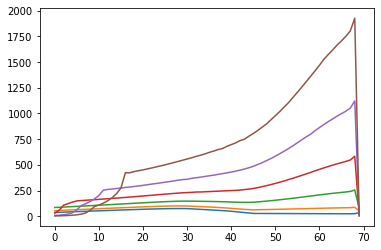

In [38]:
from matplotlib import pyplot as plt
plt.plot(C_t[10,1,:])
plt.plot(C_t[20,1,:])
plt.plot(C_t[30,1,:])
plt.plot(C_t[40,1,:])
plt.plot(C_t[50,1,:])
plt.plot(C_t[60,1,:])

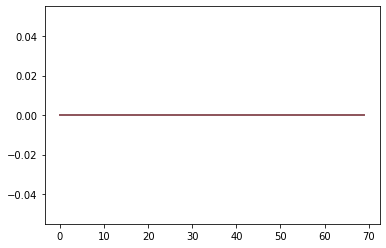

In [39]:
plt.plot(B_t[10,1,:])
plt.plot(B_t[20,1,:])
plt.plot(B_t[30,1,:])
plt.plot(B_t[40,1,:])
plt.plot(B_t[50,1,:])
plt.plot(B_t[60,1,:])

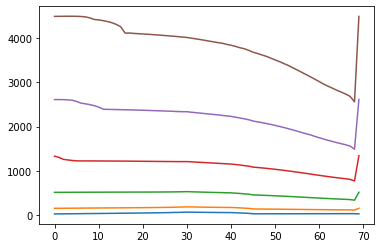

In [40]:
plt.plot(K_t[10,1,:])
plt.plot(K_t[20,1,:])
plt.plot(K_t[30,1,:])
plt.plot(K_t[40,1,:])
plt.plot(K_t[50,1,:])
plt.plot(K_t[60,1,:])

### Simulation Part

In [41]:
import quantecon as qe
mc = qe.MarkovChain(P)

def action(t, w, s, alive):
    c = interp1d(wgrid, C_t[:,s,t], kind = "cubic", fill_value = "extrapolate")(w)
    b = interp1d(wgrid, B_t[:,s,t], kind = "cubic", fill_value = "extrapolate")(w)
    k = interp1d(wgrid, K_t[:,s,t], kind = "cubic", fill_value = "extrapolate")(w)
    if not alive:
        c = 0
        b = 0
        k = 0
    return (c,b,k)
    
# Define the transtiion of state 
def fixTransition(w, s, s_next, a, alive):
    c, b, k = a
    # collect possible next state (w_next, s_next) with probability prob
    Z_next = []
    prob = []
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    r_bond = r_f[int(s)]
    r_stock = r_m[s,s_next]
    w_next = b*(1+r_bond) + k*(1+r_stock)
    if not alive:
        return 0
    return w_next

In [42]:
import random as rd
def simulation(num):
    dfs = []
    for sim in range(num):
        if sim%100 == 0:
            print(sim)
        # simulate an agent age 15 starting with wealth of 10
        w = 20
        wealth = []
        Consumption = []
        Bond = []
        Stock = []
        Salary = []
        A = []
        econState = mc.simulate(ts_length=T_max - T_min)
        alive = True
        for t in range(len(econState)-1):
            if rd.random() > prob[t]:
                alive = False
            if alive == False:
                A.append(1)
            else:
                A.append(0)
            wealth.append(w)
            s = econState[t]
            s_next = econState[t+1]
            a = action(t, w, s, alive)
            if alive:
                Salary.append(y(t+T_min, s))
            else:
                Salary.append(0)
            Consumption.append(a[0])
            Bond.append(a[1])
            Stock.append(a[2])
            w = fixTransition(w,s,s_next, a, alive)
        # dictionary of lists  
        dictionary = {'wealth': wealth,
                      'Consumption': Consumption, 
                      'Bond': Bond, 
                      'Stock': Stock,
                      'Salary': Salary,
                      'A': A}
        
        dfs.append(pd.DataFrame(dictionary)) 
    return dfs

In [43]:
sim = 1000
dfs = simulation(1000)


0
100
200
300
400
500
600
700
800
900


In [44]:
for i in range(100):
    print("index: ", i)
    print(np.where(dfs[i]["A"].values == 1)[0][0] + 20)

index:  0
71
index:  1
61
index:  2
48
index:  3
42
index:  4
20
index:  5
32
index:  6
57
index:  7
62
index:  8
47
index:  9
53
index:  10
51
index:  11
32
index:  12
53
index:  13
58
index:  14
57
index:  15
56
index:  16
58
index:  17
55
index:  18
47
index:  19
25
index:  20
37
index:  21
55
index:  22
56
index:  23
28
index:  24
40
index:  25
56
index:  26
63
index:  27
25
index:  28
32
index:  29
64
index:  30
44
index:  31
56
index:  32
37
index:  33
45
index:  34
50
index:  35
66
index:  36
55
index:  37
21
index:  38
28
index:  39
31
index:  40
21
index:  41
71
index:  42
28
index:  43
49
index:  44
46
index:  45
35
index:  46
27
index:  47
35
index:  48
68
index:  49
26
index:  50
33
index:  51
35
index:  52
34
index:  53
25
index:  54
55
index:  55
35
index:  56
51
index:  57
62
index:  58
42
index:  59
68
index:  60
31
index:  61
53
index:  62
56
index:  63
61
index:  64
41
index:  65
44
index:  66
28
index:  67
41
index:  68
68
index:  69
44
index:  70
40
index:  71
57
in

In [45]:
attributes = ["wealth", "Consumption", "Bond", "Salary"]

def collect(dfs, attribute = "wealth"):
    df = pd.DataFrame()
    for d in dfs:
        df = pd.concat([df, d[attribute]], axis=1)
    return df

def quantileMeanPlot(df, quantiles=["10%", "25%", "50%", "75%", "90%"]):
    df[["10%", "25%", "50%", "75%", "90%"]] = pd.DataFrame(data = df.quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis = 1).values.T, 
                                                           columns=["10%", "25%", "50%", "75%", "90%"])
    df['mean'] = df.mean(axis = 1)
    df[quantiles + ["mean"]].plot() 

In [46]:
wealth = collect(dfs, attribute = "wealth")
consumption = collect(dfs, attribute = "Consumption")
Bond = collect(dfs, attribute = "Bond")
Income = collect(dfs, attribute = "Salary")

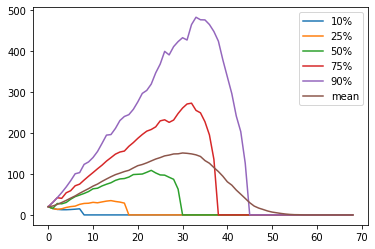

In [47]:
quantileMeanPlot(wealth)

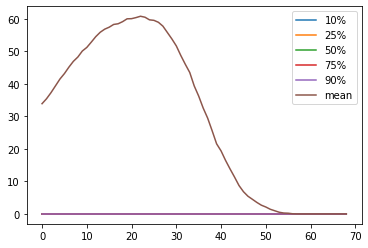

In [48]:
quantileMeanPlot(consumption)

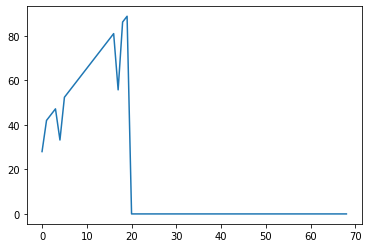

In [49]:
plt.plot(Income.iloc[:,70])

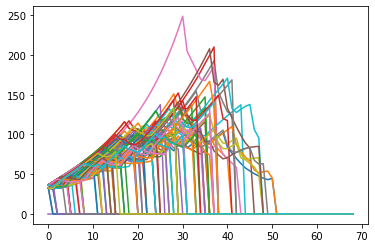

In [50]:
for i in range(100):
    plt.plot(consumption.iloc[:,i].values)

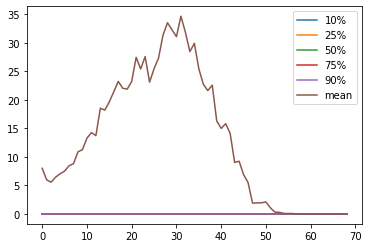

In [51]:
quantileMeanPlot(Bond)

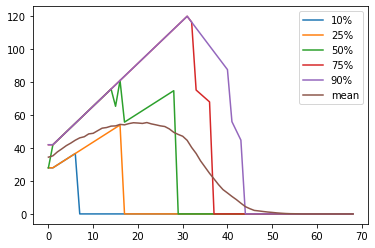

In [52]:
quantileMeanPlot(Income)

In [53]:
df = pd.DataFrame()
for d in dfs: 
    if df.size == 0:
        df = d
    else:
        df = df + d
df = df/sim

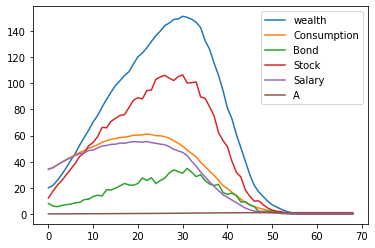

In [54]:
df.plot()

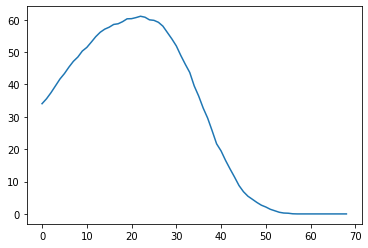

In [55]:
df.Consumption.plot()

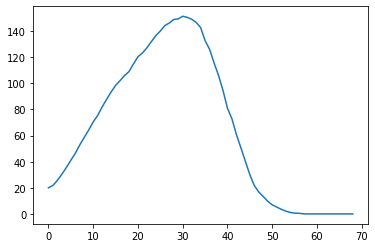

In [56]:
df.wealth.plot()

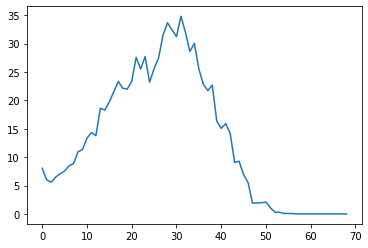

In [57]:
df.Bond.plot()

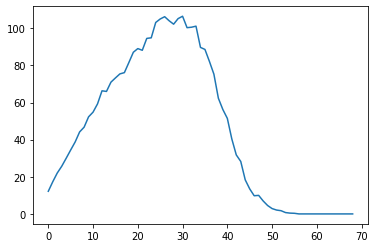

In [58]:
df.Stock.plot()

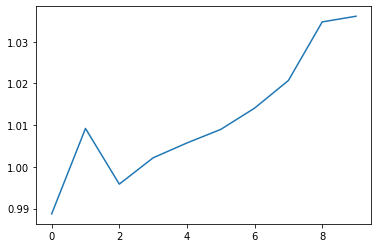

In [59]:
(df.Consumption[:10]/df.Salary[:10]).plot()

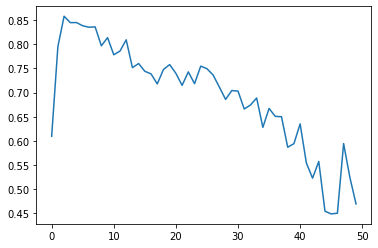

In [60]:
(df.Stock[:50]/df.wealth[:50]).plot()